# 👻 Ghost on Local
---
[![Phantom](https://img.shields.io/badge/Version-2.0-teal.svg)]()
[![Phantom](https://img.shields.io/badge/Github-👻-black.svg)](https://github.com/Ming-doan/timeseries-imputation.git)

In [2]:
import pandas as pd
from modules.alias import get_by_aliases
from modules.utils.preprocessing import Preprocessing
from modules.utils.missing import CreateMissingDataFrame
from modules import Trainer
from modules.models import *
from modules.utils.callbacks import SavePlot, Combined
from modules.utils.generator import WindowGenerator
from modules.utils.cache import Cache

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# Datasets
DATASET = 'data/PhuLien'
SELECTED_COLUMNS = ['WaterLevel']
# Missing values
MISSING_PERCENTAGE = 36
MISSING_GAPS = 1
SEED = 96841
MODE = 'Linear' # 'Random', 'Linear'
# Models
WINDOW_SIZE = 36
BATCH_SIZE = 1
MODELS = get_by_aliases(['cnn1d'])

### Preprocessing

In [3]:
import os
os.makedirs('results', exist_ok=True)

In [4]:
# Read CSV
df = pd.read_csv(f'{DATASET}.csv')
df = df[[df.columns[-1]]]

Text(0.5, 1.0, 'data/HaNoi')

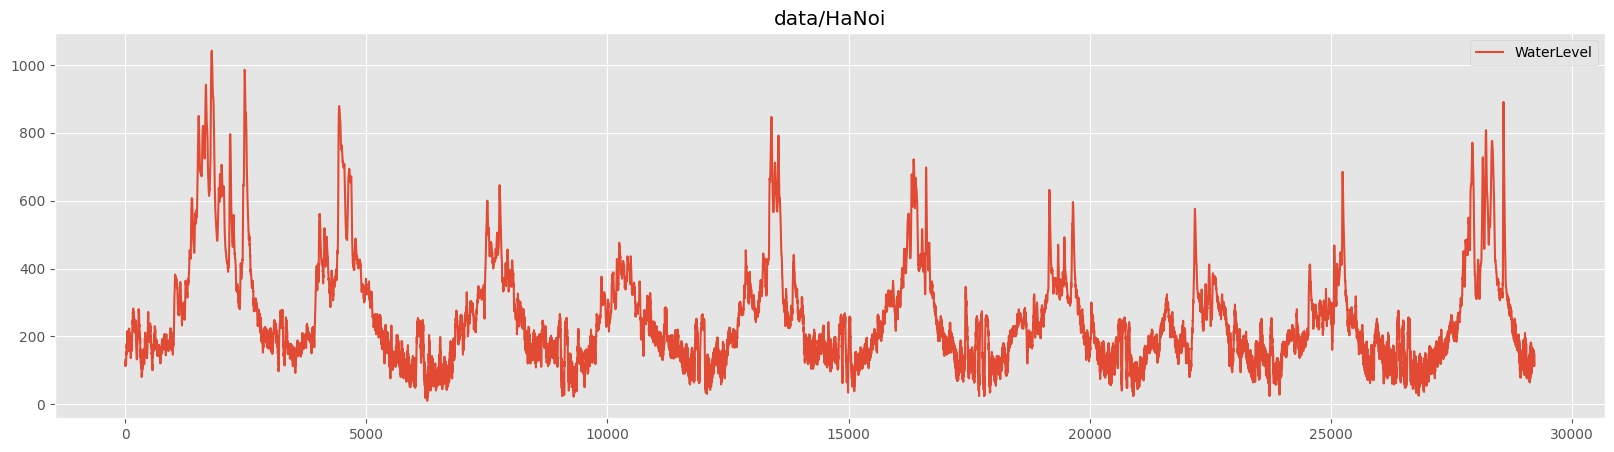

In [5]:
# Plot raw data
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df.plot(figsize=(20, 5))
plt.title(DATASET)

In [6]:
# Preprocessing data
preprocessing = Preprocessing()
df = preprocessing.flow(df)

In [7]:
# Create missing data
creator = CreateMissingDataFrame(df, MISSING_PERCENTAGE, MISSING_GAPS, split_mode=MODE, seed=SEED, is_constant_missing=True, safe_random_window=WINDOW_SIZE)

2024-06-15 12:59:31.794 | SUCCESS  | modules.utils.missing:__dropping_dataframe:169 - Dropped dataframe successfully. Missing indexs: [(13246, 13282)]


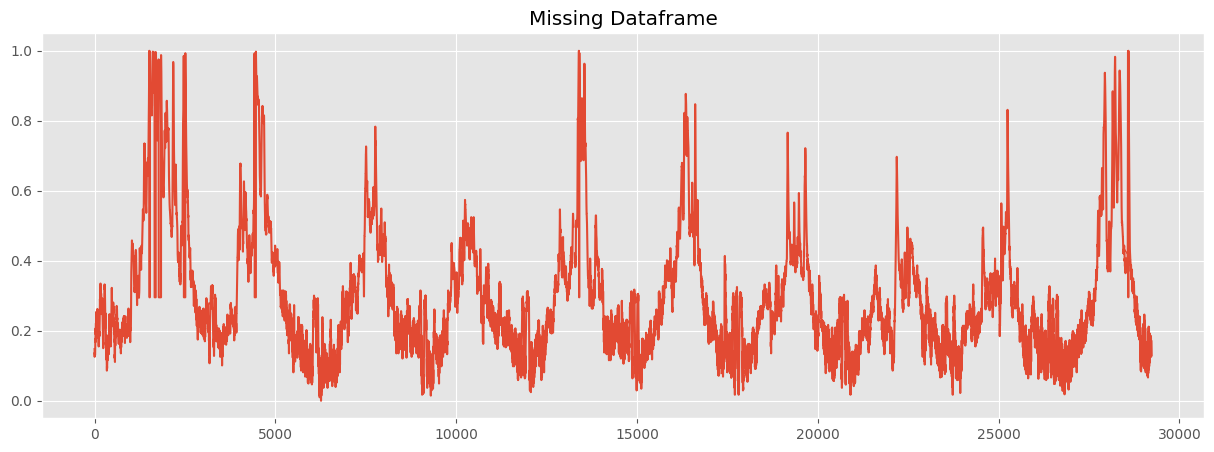

In [9]:
creator.plot()

### Training

In [10]:
# Training
trainer = Trainer(model=MODELS)
combined_callback = Combined(n_models=len(MODELS), df=creator, save_directory="results")
sp = SavePlot(n_models=len(MODELS), save_directory="results")
cache = Cache(live_cache=True)

for train_df, test_df in creator:
    train_gen = WindowGenerator(train_df, WINDOW_SIZE, BATCH_SIZE)
    test_gen = WindowGenerator(test_df, WINDOW_SIZE, BATCH_SIZE)

    trainer.train(train_gen, test_gen, callbacks=[sp, combined_callback], cache=cache)
    trainer.reset()

2024-06-15 12:59:33.992 | WARNING  | modules.train:train:69 - Window size is larger than the dataframe size. 36 >= 35. Disabling prediction.
2024-06-15 12:59:33.993 | INFO     | modules.train:train:84 - Model 1/1: KAN
2024-06-15 12:59:33.994 | INFO     | modules.train:train:89 - Fitting the model KAN


None


  0%|          | 0/13210 [00:00<?, ?it/s]

Epoch 1/20


TypeError: 'int' object is not callable

In [ ]:
combined_callback.metrics.metrics.to_csv('results/metrics.csv', index=False)
combined_callback.metrics.metrics

In [ ]:
for model in MODELS:
    print(f'{model.name}: {model.get_params()}')

In [ ]:
# Plot history
import matplotlib.pyplot as plt
for model in MODELS:
    if 'histories' in dir(model):
        try:
            fig, ax = plt.subplots(1, 2, figsize=(15, 5))
            ax[0].plot(model.histories[0].history['loss'], label='Pipeline')
            ax[0].legend()
            ax[1].plot(model.histories[1].history['loss'], label='Reverse Pipeline')
            ax[1].legend()
            fig.suptitle(f'Loss of {model.name}')
            plt.tight_layout()
        except Exception as e:
            print(e)
            print('\033[91mCannot plot history of model', model.name)